In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# import dask.dataframe as dd
from pathlib import Path
import seaborn as sns

%matplotlib inline

# Data

## Data Path

In [2]:
!ls -lah ~/Data/azure-data

total 420M
drwxrwx--- 3 rayandrew rayandrew  16K Jul 10 16:44 .
drwxrwx--- 5 rayandrew rayandrew 4.0K Jul  5 14:16 ..
-rw-rw---- 1 rayandrew rayandrew  29K Jul  3 18:10 AzurePublicDatasetLinksV2.txt
-rw-rw---- 1 rayandrew rayandrew   65 Feb 18  2020 category.txt
-rw-rw---- 1 rayandrew rayandrew   82 Feb 18  2020 cores.txt
-rw-rw---- 1 rayandrew rayandrew 1.8K Feb 18  2020 cpu.txt
-rw-rw---- 1 rayandrew rayandrew 2.0M Feb 18  2020 deployments.csv.gz
-rw-rw---- 1 rayandrew rayandrew  553 Feb 18  2020 deployment.txt
-rw-rw---- 1 rayandrew rayandrew  13K Feb 18  2020 lifetime.txt
-rw-rw---- 1 rayandrew rayandrew   75 Feb 18  2020 memory.txt
-rw-rw---- 1 rayandrew rayandrew 1.5K Feb 18  2020 schema.csv
-rw-rw---- 1 rayandrew rayandrew 344K Feb 18  2020 subscriptions.csv.gz
drwxrwx--- 2 rayandrew rayandrew  20K Jul 10 16:42 vm_cpu
-rw-rw---- 1 rayandrew rayandrew  271 Feb 18  2020 vm_memory_bucket_definition.csv
-rw-rw---- 1 rayandrew rayandrew 418M Feb 18  2020 vmtable.csv.gz
-rw-rw---- 1 r

## Schema

In [3]:
schema_df = pd.read_csv('~/Data/azure-data/schema.csv')
schema_df

,filepattern,field_number,content,format
0,vm_virtual_core_bucket_definition.csv,1,bucket,STRING
1,vm_virtual_core_bucket_definition.csv,2,definition,STRING
2,vm_memory_bucket_definition.csv,1,bucket,STRING
3,vm_memory_bucket_definition.csv,2,definition,STRING
4,subscriptions/subscriptions.csv.gz,1,subscription id,STRING_HASH
5,subscriptions/subscriptions.csv.gz,2,timestamp first vm created,INTEGER
6,subscriptions/subscriptions.csv.gz,3,count vms created,INTEGER
7,deployment/deployment.csv.gz,1,deployment id,STRING_HASH
8,deployment/deployment.csv.gz,2,deployment size,INTEGER
9,vmtable/vmtable.csv.gz,1,vm id,STRING_HASH


## Trace Data

In [4]:
data_path = '~/Data/azure-data/vmtable.csv.gz'
headers = ['vmid','subscriptionid','deploymentid','vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcategory', 'vmcorecountbucket', 'vmmemorybucket']
trace_dataframe = pd.read_csv(data_path, header=None, index_col=False,names=headers,delimiter=',')
trace_dataframe['lifetime'] = np.maximum((trace_dataframe['vmdeleted'] - trace_dataframe['vmcreated']),300)/ 3600
max_value_vmcorecountbucket = 30
max_value_vmmemorybucket = 70
trace_dataframe = trace_dataframe.replace({'vmcorecountbucket':'>24'},max_value_vmcorecountbucket)
trace_dataframe = trace_dataframe.replace({'vmmemorybucket':'>64'},max_value_vmmemorybucket)
trace_dataframe = trace_dataframe.astype({"vmcorecountbucket": int, "vmmemorybucket": int})
trace_dataframe['corehour'] = trace_dataframe['lifetime'] * trace_dataframe['vmcorecountbucket']
trace_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32,309.833333,2478.666667
1,rKggHO/04j31UFy65mDTwtjdMQL/G03xWfl3xGeiilB4/W...,ub4ty8ygwOECrIz7eaZ/9hDwnCsERvZ3nJJ03sDSpD85et...,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHFmyJ...,424500,425400,37.879261,3.325358,37.879261,Unknown,4,32,0.250000,1.000000
2,YrR8gPtBmfNaOdnNEW5If1SdTqQgGQHEnLHGPjySt53bKW...,9LrdYRcUfGbmL2fFfLR/JUg2OTkjGRe3iluwIhDRPnPDPa...,GEyIElfPSFupze8T+T1niQMepeqG88VpLNuxUMyIDbz8VF...,1133100,1133700,0.304368,0.220553,0.304368,Unknown,4,32,0.166667,0.666667
3,xzQ++JF1UAkh70CDhmzkiOo+DQn+E2TLErCFKEmSswv1pl...,0XnZZ8sMN5HY+Yg+0dykYB5oenlgsrCpzpgFSvn/MX42Ze...,7aCQS6fPUw9rwCPiqvghk/WCEbMV3KgNJjA+sssdfY5Ybl...,0,2591400,98.573424,30.340054,98.212503,Interactive,2,4,719.833333,1439.666667
4,vZEivnhabRmImDr+JqKqZnpIM3WxtypwoxjfjnklR/idyR...,HUGaZ+piPP4eHjycCBki2yq0raJywdzrVuriR6nQceH3hA...,/s/D5VtTQDxyS6wq7N/VQAMczx61Ny1Ut3a3iFmDSOCXxp...,228300,229800,82.581449,13.876299,82.581449,Unknown,2,4,0.416667,0.833333


In [5]:
trace_dataframe.vmcorecountbucket.unique()

array([ 8,  4,  2, 24, 30])

In [6]:
TraceLegend = "Azure 2019 - Public Dataset V2"
def CPUPlot(df):
    counts_AVG = pd.DataFrame(df.groupby('avgcpu').size().rename('Freq')).reset_index()
    counts_P95 = pd.DataFrame(df.groupby('p95maxcpu').size().rename('Freq')).reset_index()
    counts_AVG = counts_AVG.rename(columns={'avgcpu': 'Bucket'})
    counts_P95 = counts_P95.rename(columns={'p95maxcpu': 'Bucket'})
    counts_AVG['cum'] = counts_AVG['Freq'].cumsum() / counts_AVG['Freq'].sum() * 100
    counts_P95['cum'] = counts_P95['Freq'].cumsum() / counts_P95['Freq'].sum() * 100
    ax = counts_AVG.plot(x='Bucket', y='cum',linestyle='--', color='b', title="VM CPU Utilization",logx=False, legend=True, ylim=(0,100), yticks=range(0,110,20))
    counts_P95.plot(x='Bucket', y='cum', linestyle='--', logx=False, color='b', ax=ax)
    ax.text(9, 85, 'Average', size=11, weight='bold')
    ax.text(50, 45, 'P95 Max',  size=11, weight='bold')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('CPU Utilization (%)')
    ax.set_ylabel('CDF')
    ax.set_xlim([1,100])
    ax.legend([TraceLegend], loc='best');
    ax.minorticks_off()


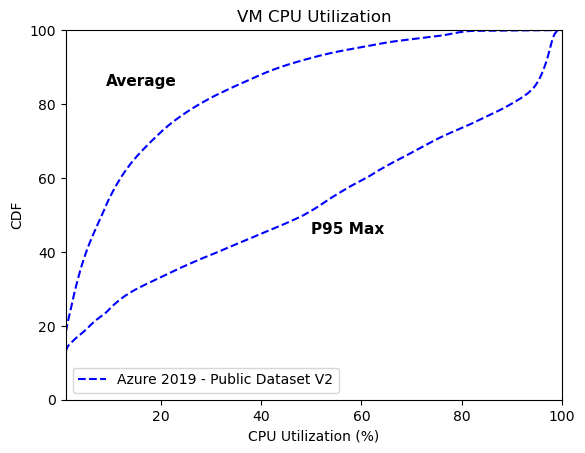

In [7]:
CPUPlot(trace_dataframe)

<Axes: xlabel='x', ylabel='p95maxcpu'>

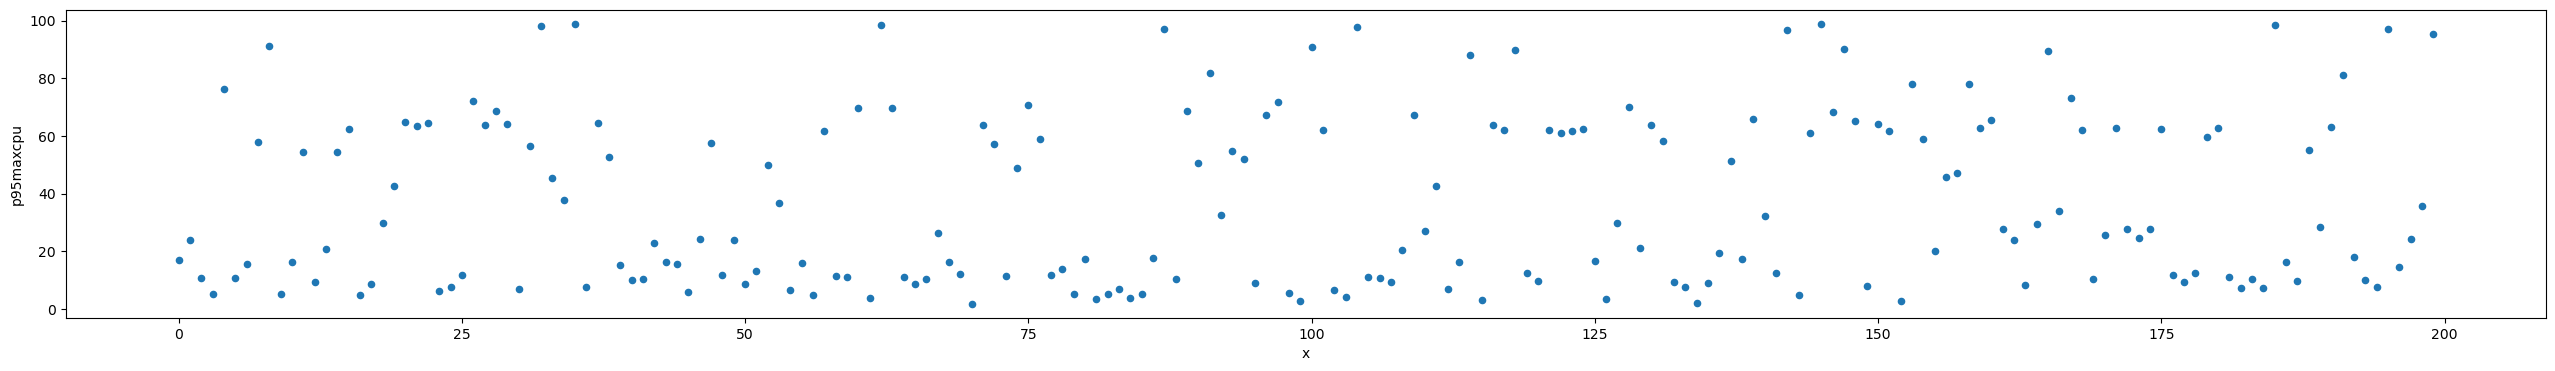

In [8]:
data = trace_dataframe.sort_values(by=["vmcreated"]).reset_index(drop=True)
data["x"] = data.index

fig, ax = plt.subplots(figsize=(32, 4))
data.iloc[0:200].plot.scatter(x="x", y="p95maxcpu", ax=ax)
# fig.savefig("plot.png", dpi=300)

## Deployment Data

In [9]:
deployment_data_path = '~/Data/azure-data/deployments.csv.gz'
deployment_headers=['deploymentid','deploymentsize']
deployment_trace_dataframe = pd.read_csv(deployment_data_path, header=None, index_col=False,names=deployment_headers,delimiter=',')
deployment_trace_dataframe.head()

,deploymentid,deploymentsize
0,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,11
1,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHF+kd...,9
2,/+3IQ9csEUWlX/OR5lHSiUh+EH54WfI9nfpjniqCk/cQig...,2
3,/5mEvsIGOul7DM6xGef5rE1u0TZg4N7dkSmotRO1D87M8i...,23
4,/DrUXkHMnF+IdCiFWiT06P/2CZBiZ7Y1WLfTZGV7hU868C...,11


In [93]:
first_deployment_id = deployment_trace_dataframe.iloc[0].deploymentid
first_deployment_id

'+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3P3NIjsmoIBcySwoQwPj8fnC+cxTPRCj5oX6YlU0g=='

## Subscription Data

In [10]:
subscription_data_path= '~/Data/azure-data/subscriptions.csv.gz'
subscription_headers=['subscriptionid', 'vmcreated', 'vmcount']
subscription_trace_dataframe = pd.read_csv(subscription_data_path, header=None, index_col=False,names=subscription_headers,delimiter=',')
subscription_trace_dataframe.head()

,subscriptionid,vmcreated,vmcount
0,/YdjZT4MloSQErgc+pr6xPdxhPDK2DdCHz3v1uYvb+RQPb...,418200,2
1,1owRC8fAiTkftDDmemUYdXtzzmnuOoKN1keoqCE0SkllaU...,0,8947
2,1wYls1fw1ahqoRuYgqTwW1CWwFCA+GhM8bUdE2ZnE3QEUi...,0,6057
3,37GxzuLNVu9neuiSXk/RMGqW2vCOIkF0aSGdIdR5QaMqSj...,0,31
4,4JEvQIV0SLuz6P+rPxPQCIZTOsDW2Y9wUPPMwQxL4sJ0ob...,0,1


In [11]:
first_id = trace_dataframe.iloc[0].vmid
trace_dataframe[trace_dataframe.vmid == first_id]

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.75963,Delay-insensitive,8,32,309.833333,2478.666667


## Virtual Core Bucket

In [12]:
virtual_core_bucket_df = pd.read_csv("~/Data/azure-data/vm_virtual_core_bucket_definition.csv")
with pd.option_context('display.max_colwidth', None):
    display(virtual_core_bucket_df.head())

,2,VM Virtual Core Count >0 and VM Virtual Core Count <=2
0,4,VM Virtual Core Count >2 and VM Virtual Core Count <=4
1,8,VM Virtual Core Count >4 and VM Virtual Core Count <=8
2,12,VM Virtual Core Count >8 and VM Virtual Core Count <=12
3,24,VM Virtual Core Count >12 and VM Virtual Core Count <=24
4,>24,VM Virtual Core Count >24


## Virtual Memory Bucket

In [13]:
virtual_mem_bucket_df = pd.read_csv("~/Data/azure-data/vm_memory_bucket_definition.csv")
with pd.option_context('display.max_colwidth', None):
    display(virtual_mem_bucket_df.head())

,2,VM Memory (GB) >0 and VM Memory (GB) <=2
0,4,VM Memory (GB) >2 and VM Memory (GB) <=4
1,8,VM Memory (GB) >4 and VM Memory (GB) <=8
2,32,VM Memory (GB) >8 and VM Memory (GB) <=32
3,64,VM Memory (GB) >32 and VM Memory (GB) <=64
4,>64,VM Memory (GB) >64


# Training

In [15]:
first_sub_id = trace_dataframe.iloc[0].subscriptionid
trace_dataframe[trace_dataframe.subscriptionid == first_sub_id]

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32,309.833333,2478.666667
36,az9PsmT1Uf7lNht47EN816B/J4Y3BNmeDpo5Mh0L8X4wb+...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIDFnp...,296700,304800,60.376541,0.909215,33.794172,Unknown,8,32,2.250000,18.000000
26612,0srweqXENY4Fs5SXZ7dvG6pcHKaWOV9N4I4aROjX8JJ7EF...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,1674300,1858800,60.520592,0.859547,23.136785,Unknown,8,32,51.250000,410.000000
48570,2CyK4hLH4vH1tuHjTtlK7wjD0jcV2FZvOuJdzOmRhF1ePe...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIDFnp...,0,2591400,99.480090,0.713276,17.341075,Delay-insensitive,8,32,719.833333,5758.666667
65517,sFjX0KCK5sMQ9oVuKGFRNDTd8P8jdPKCBX8ppks/rht7I5...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,1674000,2212800,95.337247,0.925803,20.259550,Unknown,8,32,149.666667,1197.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639007,+xPfpOoEaRz81ZcKapo1e6HIXAUEnCxOhkgcqgxGNm06fI...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBEyg...,1943400,2591400,76.061113,1.270474,8.726251,Delay-insensitive,4,32,180.000000,720.000000
2640773,gz0+Wzr+H2yGT5jtD/5Z0WlOkWmR173DNIfNpnX4IHPrli...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIDFnp...,0,2591400,93.893440,0.542477,14.299262,Delay-insensitive,8,32,719.833333,5758.666667
2657863,GM8xMlJM2KjYmjyPLJ8nEvXlJS9DisVf44gi4Nx2eD5Epr...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,543900,544500,34.513341,7.302797,34.513341,Unknown,8,32,0.166667,1.333333
2677526,F/UMqPOjP6D+zhcVtaIJqrqk8lcWuDbikhG2co8T03nYcm...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIDFnp...,0,2591400,26.245418,1.120076,4.593171,Interactive,2,2,719.833333,1439.666667


In [16]:
subscription_trace_dataframe[subscription_trace_dataframe.subscriptionid == first_sub_id]

,subscriptionid,vmcreated,vmcount
6427,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,0,204


In [94]:
mod_trace_dataframe = trace_dataframe.copy()
# mod_trace_dataframe["p95maxcpu_percent"] = mod_trace_dataframe["p95maxcpu"].apply(np.ceil)
# mod_trace_dataframe = mod_trace_dataframe.astype({"p95maxcpu_percent": int})
# mod_trace_dataframe.head()
mod_trace_dataframe[mod_trace_dataframe.deploymentid == first_deployment_id]

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour
46358,1RSQRic4F538p1ldl0P7nz77hIyOEYE4qlH5lCI8cKVDlz...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496700,63.038500,16.912554,63.038500,Unknown,4,32,0.250000,1.000000
290056,NblJR9aBV92Wdg0e3rn+P9yYVY/WgRNLjXcZ1Ebb0gx5jK...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496700,30.336439,6.313974,30.336439,Unknown,4,32,0.250000,1.000000
477554,Lsr2CjCJHlWGZSZr2bKyXRaDAUOs2dyqZfHda6TYvWuvTe...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496700,44.460565,14.754594,44.460565,Unknown,4,32,0.250000,1.000000
548651,C+3AAcKPf+qFJvaci/68WT1yTZhY1v9sZCCW6Qw135y7jy...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496400,20.676963,4.855649,20.676963,Unknown,4,32,0.166667,0.666667
598567,7jXnGbeR2SJ2cUXClWkN14GLbEksJsT3pO74cV99XYZ49H...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1496100,1496700,20.187689,11.713947,20.187689,Unknown,4,32,0.166667,0.666667
776181,pw6+SjOlMHIMHGYqN9nPEoZ9d5d5nw8uLGayy+w0kCXy/k...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1496400,1496400,16.928697,12.150578,16.928697,Unknown,4,32,0.083333,0.333333
873877,Bbun1Vug0r4d5+IWtPfzLHuLE3gzMe5wgUpJ2Exe03B2rz...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1496400,1496700,10.021930,7.266979,10.021930,Unknown,4,32,0.083333,0.333333
1135914,q70zXY3IsxxBW7ofobMw7z10+Iw4aErg/vumlsmjTQR+tL...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496700,47.278499,13.623377,47.278499,Unknown,4,32,0.250000,1.000000
1324795,1OZW+Ecye6U/tg94hEwJyOB2HHW5odGfgPnStg0xvSEtTs...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1495800,1496700,32.002482,10.443916,32.002482,Unknown,4,32,0.250000,1.000000
1400938,8D3jblEMTxOhyJKemgYhNdOcDaIcqGelTI0CeCfBjRU3nw...,EndoySZxCRcGrgGc8+7LOBu2lhOqiUUnhySWzZ/WJDCwM9...,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,1496100,1496700,12.515723,7.598802,12.515723,Unknown,4,32,0.166667,0.666667


In [95]:
deployment_trace_dataframe[deployment_trace_dataframe.deploymentid == first_deployment_id]

,deploymentid,deploymentsize
0,+EZ/AWPlMyGxKY9bSsXYV+nf3hgJLlR7kNJPNNJDerKjM3...,11


In [96]:
deployment_trace_dataframe.deploymentsize.unique()

array([  11,    9,    2,   23,    1,   10,   19,    5,   14,    7,    4,
          6,   12,   31,    3,  261,   54,   63,    8,   45,   22,  267,
         18,   32,  317,   29,   25,   17,   40,  116,   75,   56,   15,
         43,  184,   50,   13,   21,  112,   33,   39,   70,   92,   24,
        245,  992,   59,   97,   26,   41,  278,  236,   16,   36,  136,
         42,   46,   20,   27,  522,   69,   28,   49,   51,   57,  200,
        194,  258,   44,   48,  117,   30,  197,  262,   77,   34,   91,
        924,  752,   94,  101,   89,   67,   66,   64,  290,   93,   35,
         85,   55,   88,   73,  107,  389,  287,  231,  326,  284,   65,
        147,  221,  115,  185,  343,  230,   71,  100,  363,  103,  291,
        314,  392,   38,  106,  202,  225,  697,  110,  193,  137,   60,
        437,  323,   98,  981,   86,  218,  359,   37,  131,  307,   58,
        163,  283,  690,  135,  182,  246,  206,  122,  978,   52,  336,
         53,  187,   96,  219,  178,  165,  150,  1

In [90]:
%%time

def feats_bucket_cpu_transform(df):
    df = df.copy()
    df["p95maxcpu_percent"] = df["p95maxcpu"].apply(np.ceil)
    df = df.astype({"p95maxcpu_percent": int})
    percent_df = pd.get_dummies(df.p95maxcpu_percent, prefix="percent", dtype=int)
    df = pd.concat([df, percent_df], axis=1)
    percent_columns = [f'percent_{i}' for i in range(0, 101)]
    df[percent_columns] = df.groupby(by=['subscriptionid'])[percent_columns].transform(lambda x: x.cumsum())
    df = df.drop(columns=["p95maxcpu_percent"])
    return df

def feats_one_hot(df, col, drop_first=True):
    df = df.copy()
    vmcategory_df = pd.get_dummies(test_df[col], prefix=col, dtype=int, drop_first=True)
    df = pd.concat([df, vmcategory_df], axis=1)
    df = df.drop(columns=[col])
    return df

def drop_others(df):
    df = df.copy()
    df = df.drop(columns=['vmid', 'subscriptionid', 'deploymentid', 'vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'vmcategory', 'vmcorecountbucket', 'vmmemorybucket', 'lifetime', 'corehour'], errors="ignore")
    return df

def discretize_column(df, col, n_bins=4, new_col=None, fr=0, to=100):
    # column = df[col]
    # column = np.clip(column, fr, to)
    if new_col == None:
        new_col = col
    # print( pd.cut(df[col].clip(fr, to), bins=n_bins, labels=False))
    df = df.copy()
    df[new_col] = pd.cut(df[col].clip(fr, to), bins=n_bins, labels=False)
    return df
    
    

test_df = trace_dataframe.copy()
test_df = feats_bucket_cpu_transform(test_df)
test_df = feats_one_hot(test_df, "vmcategory")
test_df = feats_one_hot(test_df, "vmcorecountbucket")
test_df = feats_one_hot(test_df, "vmmemorybucket")
test_df = discretize_column(test_df, col="p95maxcpu", n_bins=4, new_col="p95maxcpu_bucket", fr=0, to=100)
test_df = drop_others(test_df)
print(len(test_df.columns))
test_df.head()

114
CPU times: user 6.9 s, sys: 2.66 s, total: 9.55 s
Wall time: 9.57 s


,p95maxcpu,percent_0,percent_1,percent_2,percent_3,percent_4,percent_5,percent_6,percent_7,percent_8,...,vmcorecountbucket_4,vmcorecountbucket_8,vmcorecountbucket_24,vmcorecountbucket_30,vmmemorybucket_4,vmmemorybucket_8,vmmemorybucket_32,vmmemorybucket_64,vmmemorybucket_70,p95maxcpu_bucket
0,20.759630,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,37.879261,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
2,0.304368,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,98.212503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
4,82.581449,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3


In [63]:
# a = 0
# c = test_df[test_df.subscriptionid == first_sub_id].iloc[-1]
# for i in range(0, 101):
#     percent = f'percent_{i}'
#     a += c[percent]
#     # print(a)
#     # break
# a

204

In [64]:
# a = 0
# c = test_df[test_df.subscriptionid == trace_dataframe.iloc[1].subscriptionid].iloc[-1]
# for i in range(0, 101):
#     percent = f'percent_{i}'
#     a += c[percent]
#     # print(a)
#     # break
# print(len(test_df[test_df.subscriptionid == trace_dataframe.iloc[1].subscriptionid]), a)

269 269


In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(test_df.drop(columns=["p95maxcpu", "p95maxcpu_bucket"]), test_df["p95maxcpu_bucket"], test_size=0.33)

In [100]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

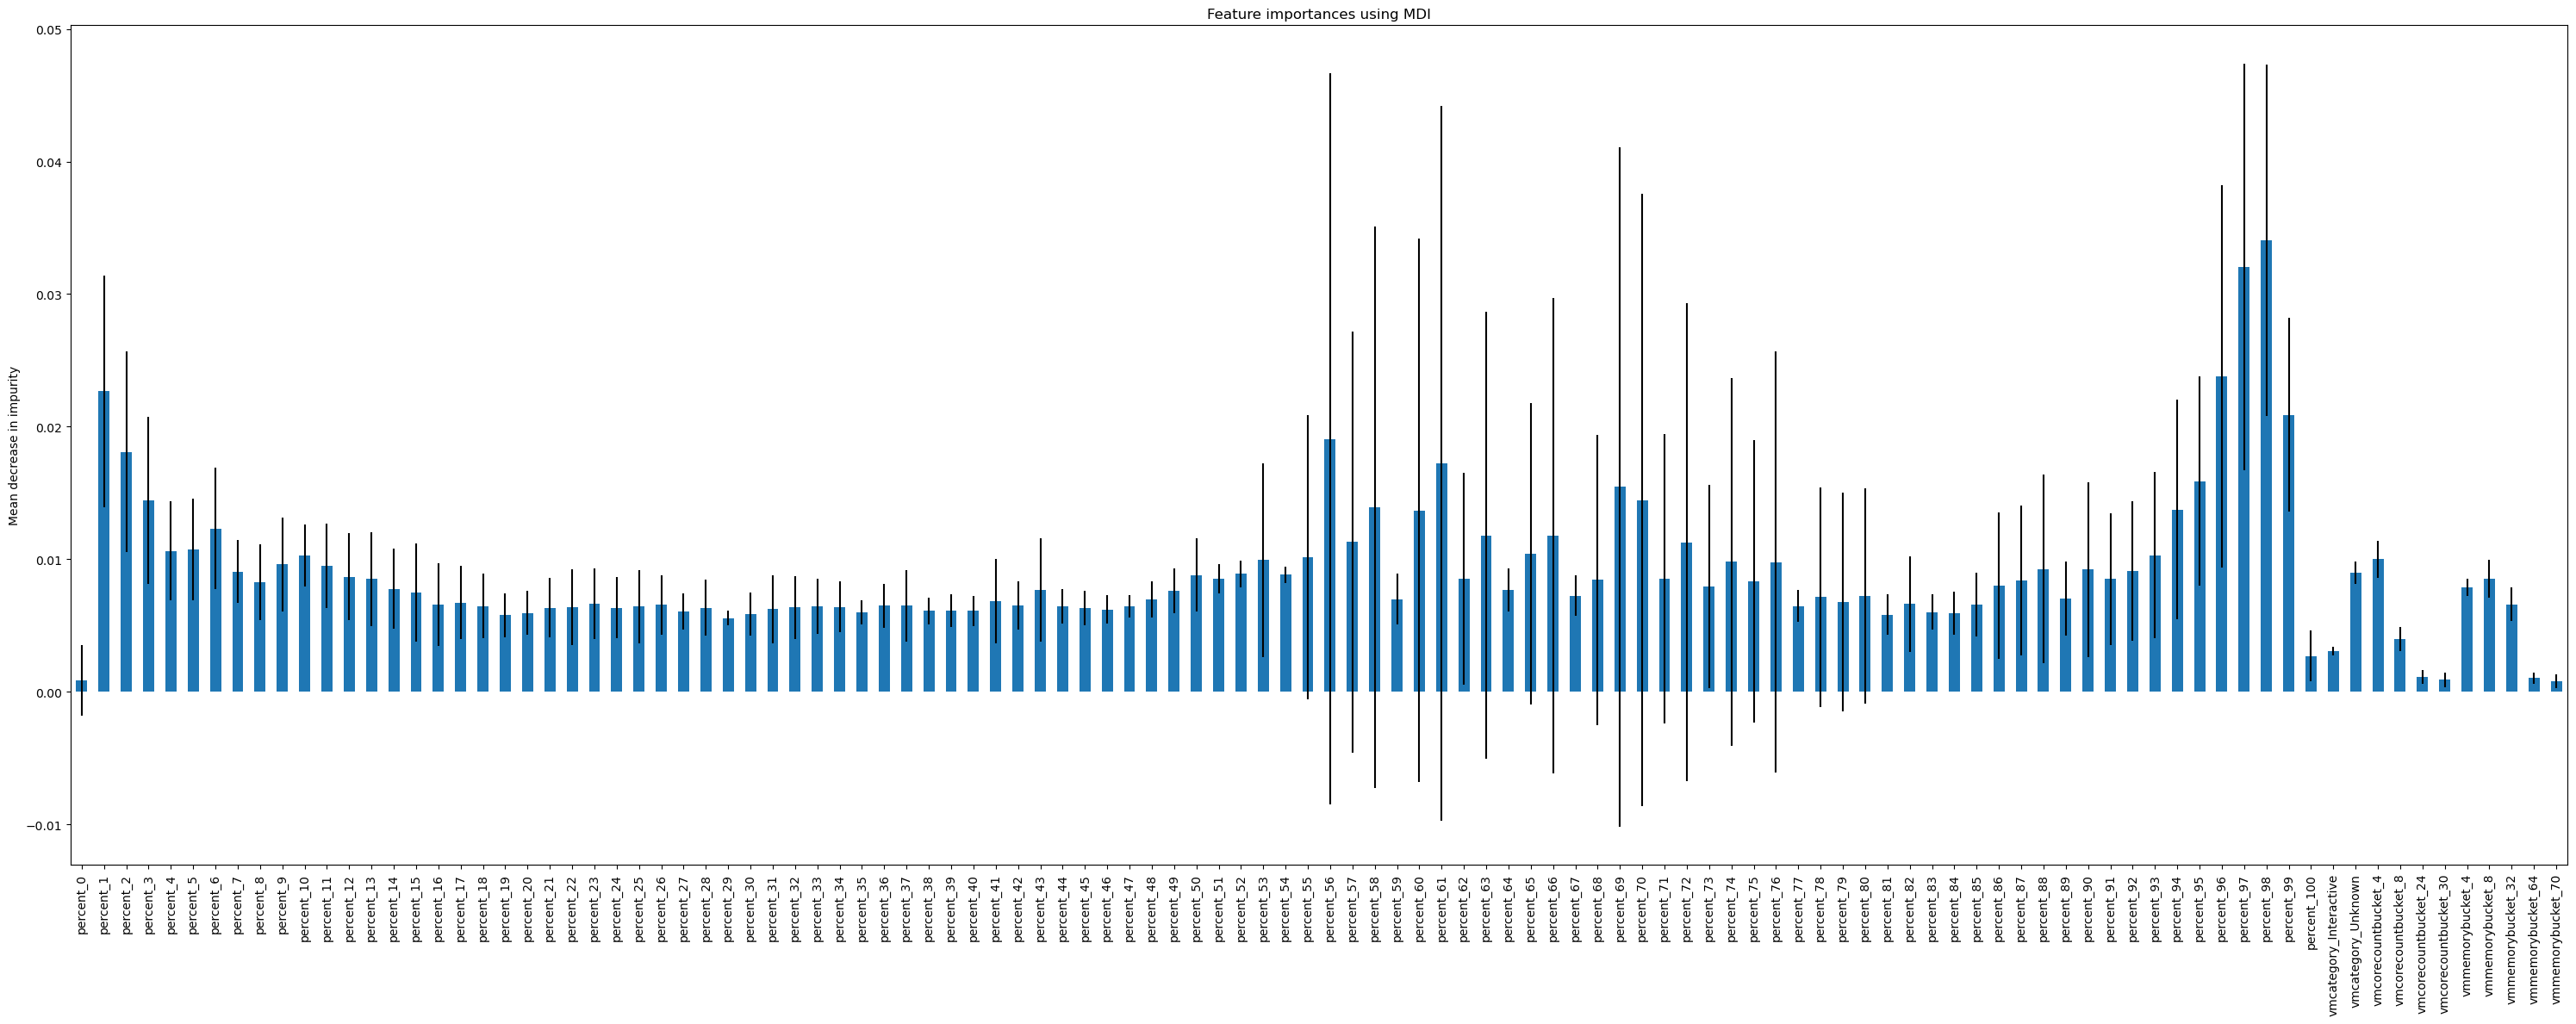

In [112]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)


# feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
feature_names = [col for col in test_df.columns if col not in ["p95maxcpu", "p95maxcpu_bucket"]]
forest_importances = pd.Series(importances, index=feature_names)


fig, ax = plt.subplots(figsize=(30, 12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [113]:
y_score = rf.predict_proba(X_test)

In [122]:
y_pred = rf.predict(X_test)

In [114]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(889531, 4)

Micro-averaged One-vs-Rest ROC AUC score:
0.81
Macro-averaged One-vs-Rest ROC AUC score:
0.78


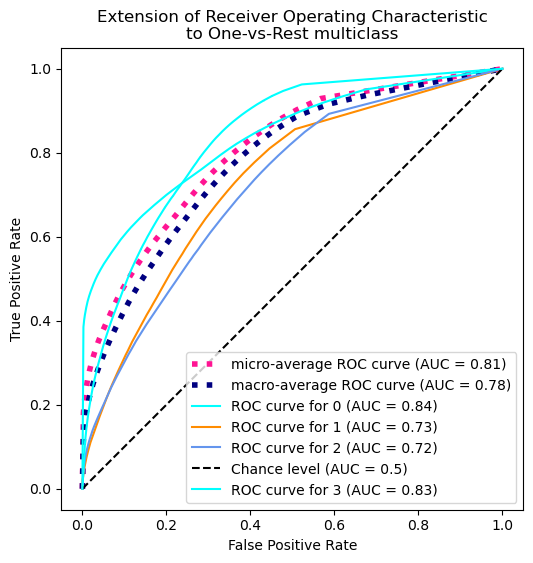

In [118]:
from itertools import cycle
from sklearn.metrics import auc, roc_curve

fig, ax = plt.subplots(figsize=(6, 6))
target_names = [0, 1, 2, 3]
n_classes = len(target_names)

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [132]:
y_test

2430491    0
1566018    0
564599     3
2111139    3
153593     3
          ..
2359599    2
2201605    3
67183      0
411778     0
615658     0
Name: p95maxcpu_bucket, Length: 889531, dtype: int64

In [133]:
y_pred

array([0, 1, 3, ..., 0, 1, 0])

In [123]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5528486359665936

In [124]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='macro')

0.500672237853798

In [125]:
precision_score(y_test, y_pred, average='micro')

0.5528486359665936

In [126]:
precision_score(y_test, y_pred, average='weighted')

0.5473661490687755

In [127]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro')

0.49965567337712036

In [128]:
recall_score(y_test, y_pred, average='micro')

0.5528486359665936

In [129]:
recall_score(y_test, y_pred, average='weighted')

0.5528486359665936

In [134]:
# trace_dataframe.to_parquet("vmtable.parquet", engine="fastparquet")